### Plot T1Disp results using the DataFrame stored in T1DispResults.pcl 

In [23]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,copy
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import griddata
import itertools

pd.options.mode.chained_assignment = None #Disable copy warnings
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [20]:
def getContour(xpts,ypts,zpts,levels,ylog=False,xlog=False):
    """
    Uses pyplot tricontour method to obtain contour
    curves in a 2D plane.

    :return: A dictionary with a list of contours for each level
    """
    
    fig = plt.figure()
    x = copy.deepcopy(xpts)
    y = copy.deepcopy(ypts)
    z = copy.deepcopy(zpts)
    
    #Use log scale:
    if ylog:
        y = np.log10(y)
    if xlog:
        x = np.log10(x)
    
    CS = plt.tricontour(x,y,z,levels=levels)    
    levelPts = {}
    for il,level in enumerate(CS.levels):
        levelPts[level] = []
        c = CS.collections[il]        
        paths = c.get_paths()
        for path in paths:
            levelPts[level].append(path.vertices)
    plt.close(fig)
    
    #scale back:
    if ylog or xlog:
        for key,ptsList in levelPts.items():
            newList = []
            for pts in ptsList:
                xpts = pts[:,0]
                ypts = pts[:,1]
                if xlog:
                    xpts = 10**xpts
                if ylog:
                    ypts = 10**ypts
                newList.append(np.column_stack((xpts,ypts)))
            levelPts[key] = newList
        
    
    return levelPts

In [21]:
def getSmoothCurve(x,y,z,stepX=20.,stepY=0.5,doLog=True,doMax=True,cval=1.):

    if doLog:
        yv = np.log10(y[y > 0.]).tolist()
        xv = x[y > 0.].tolist()
        zv = z[y > 0.].tolist()
    else:
        yv = y.tolist()
        xv = x.tolist()    
        zv = z.tolist()
    
    points = list(zip(xv,yv))
    xbins = np.arange(min(xv),max(xv),stepX)
    ybins = np.arange(min(yv),max(yv),stepY)
    zvals = np.array([[0.]*len(ybins)]*len(xbins))
    for ipt,pt in enumerate(points):
        if not (xbins.min() < pt[0] < xbins.max()):
            continue
        if not (ybins.min() < pt[1] < ybins.max()):
            continue
        ix = np.searchsorted(xbins,pt[0])-1
        iy = np.searchsorted(ybins,pt[1])
        if doMax:
            zvals[ix,iy] = max(zvals[ix,iy],zv[ipt])
        else:
            if zvals[ix,iy] == 0.:
                zvals[ix,iy] = zv[ipt]
            else:
                zvals[ix,iy] += zv[ipt]
                zvals[ix,iy] = zvals[ix,iy]/2.            

        
    xpoints = []
    ypoints = []
    zpoints = []
    for ix,xval in enumerate(xbins):
        for iy,yval in enumerate(ybins):
            xpoints.append(xval)
            ypoints.append(yval)
            zpoints.append(zvals[ix,iy])
    cs = plt.tricontour(xpoints,ypoints,zpoints,levels=[cval],linewidths=0)
    curve = None
    for c in cs.collections[0].get_paths():
        if curve is None:
            curve = c.vertices
        elif len(c.vertices) > len(curve):
            curve = c.vertices
    plt.cla()
    if doLog:
        curve[:,1] = np.power(10,curve[:,1])
    return curve

In [3]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('T1DispResults.pcl')
#print(dataDF.columns.values.tolist()) #Print all columns names

In [4]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=True)
#Add simple flag for excluded points:
dataDF['excluded'] = dataDF['ExptRes.result0.r'] > 1.
#Replace zero widths by small value:
# dataDF = dataDF[dataDF['width.37'] > 0.]
dataDF['width.1000021'] = dataDF['width.1000021'].map(lambda x: x if x > 0. else 1e-50)
dataDF['ctau.1000021'] = 1.967e-16/dataDF['width.1000021']
# #Restrict ctau range:
# dataDF = dataDF[(dataDF['ctau.37'] > 0.01) & (dataDF['ctau.37'] < 1e5)]

### Get data for plotting

In [5]:
mG = dataDF['mass.1000021']
ctau = dataDF['ctau.1000021']
r = dataDF['ExptRes.result0.r']
x,y,z = mG,ctau,r

In [6]:
#Get more points for smooth plotting
pts = np.column_stack((x, np.log10(y)))
xnew = np.linspace(min(x),max(x),500)
ynew = np.linspace(np.log10(min(y)),np.log10(max(y)),500)
newpts = np.array(list(itertools.product(xnew,ynew)))
znew = griddata(pts,r,newpts)
#Rescale y points:
newpts[:,1] = 10**newpts[:,1]

### Get official curves

In [7]:
excDispATLAS = np.genfromtxt('Table9_Obs_converted.csv',delimiter=',',
                       names=True) #Displaced Jets (ATLAS-SUSY-2016-08)
excPromptATLAS = np.array([[2020.,1e-8],[2020,1e-3]]) #ATLAS-SUSY-2016-07
excPromptCMS = np.array([[2010.,1e-8],[2010,1e-3]]) #CMS-SUS-19-006
excRHadronATLAS =  np.genfromtxt('Table15_ExclusionObs.csv',delimiter=',',skip_header=10,
                       names=True, converters = {'SIMULATED_LIFETIME_GEV' : lambda x: max(1e-25,float(x))}) #HSCP/R-Hadrons (ATLAS-SUSY-2016-32)

#Convert to c*tau:
excDispATLAS = np.column_stack((excDispATLAS['Observed_limit_GeV'],1.967e-16/excDispATLAS['width_GeV']))
excRHadronATLAS = np.column_stack((excRHadronATLAS['OBS_LIMIT_GEV'],
                                   1.967e-16/excRHadronATLAS['SIMULATED_LIFETIME_GEV']))


### Get SModelS exclusion

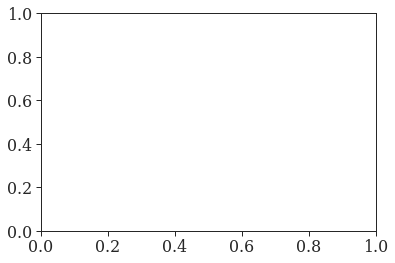

In [41]:
#Try to get smooth curve
curve = getSmoothCurve(newpts[:,0],newpts[:,1],znew,stepX=50.,stepY=0.5,doLog=True,doMax=True)

In [42]:
excCurve = getContour(mG,ctau,r,levels=[1.0],ylog=True)

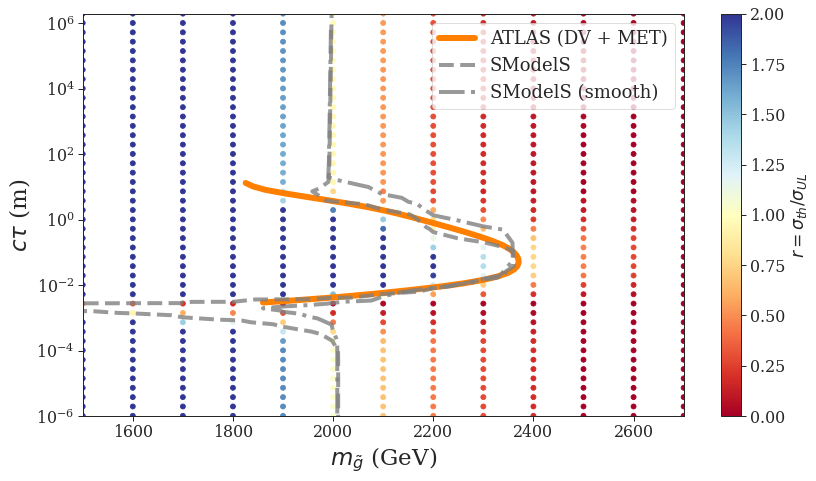

In [45]:
plt.figure(figsize=(12,7))

cp = plt.scatter(mG,ctau, c=r, vmin=0., vmax=2., s=25,
#                  cmap=sns.color_palette("light:b", as_cmap=True),
#                 cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
#                  cmap=sns.color_palette("Blues", as_cmap=True)
                 cmap=cm
                )

# colors = sns.color_palette("Paired",10)
colors = sns.color_palette("Paired",10)
colorDict = {'ATLAS (prompt)' : colors[0],
            'CMS (prompt)' :  colors[1],
            'ATLAS (R-Hadron)' :  colors[3],
            'ATLAS (DV + MET)' :  colors[7]}



# plt.plot(excPromptATLAS[:,0],excPromptATLAS[:,1],linewidth=6,c=colorDict['ATLAS (prompt)'],
#          linestyle='-',label='ATLAS (prompt)')
# plt.plot(excPromptCMS[:,0],excPromptCMS[:,1],linewidth=6,c=colorDict['CMS (prompt)'],
#          linestyle='-',label='CMS (prompt)')
plt.plot(excDispATLAS[:,0],excDispATLAS[:,1],linewidth=6,c=colorDict['ATLAS (DV + MET)'],
         linestyle='-',label='ATLAS (DV + MET)')
# plt.plot(excRHadronATLAS[:,0],excRHadronATLAS[:,1],linewidth=6,c=colorDict['ATLAS (R-Hadron)'],
# #          linestyle='-',label='ATLAS (R-Hadron)')

plt.plot(excCurve[1.0][1][:,0],excCurve[1.0][1][:,1],color='gray',linewidth=4,
         linestyle='--',label='SModelS',alpha=0.8)
plt.plot(curve[:,0],curve[:,1],color='gray',linewidth=4,
         linestyle='-.',label='SModelS (smooth)',alpha=0.8)



cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m_{\tilde g}$ (GeV)',fontsize=23)    
plt.ylabel(r'$c\tau$ (m)',fontsize=23)
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(1e-6,newpts[:,1].max())
plt.xlim(1500,2700)
# plt.title(r'$p p \to \tilde g \tilde g, \tilde g \to q q + \tilde \chi_1^0$',fontsize=20)
plt.legend(loc='upper right', fontsize=18)
plt.tight_layout()
# plt.savefig('T1Disp_exclusion0.png')
plt.show()

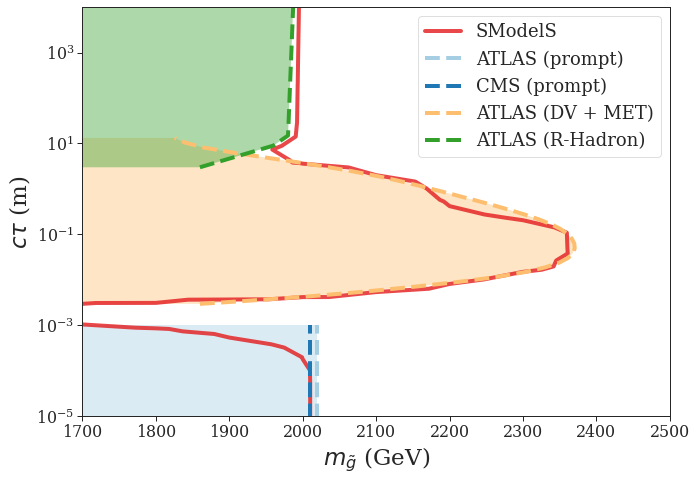

In [40]:
plt.figure(figsize=(10,7))

# cp = plt.scatter(newpts[:,0],newpts[:,1], c=znew, vmin=0., vmax=2., s=25, 
#                  cmap=sns.color_palette("light:b", as_cmap=True),
#                 cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))
#                  cmap=sns.color_palette("Blues", as_cmap=True))
#                  cmap=cm)

colors = sns.color_palette("Paired",10)
# colors = sns.color_palette("colorblind",10)
colorDict = {'ATLAS (prompt)' : colors[0],
            'CMS (prompt)' :  colors[1],
            'ATLAS (R-Hadron)' :  colors[3],
            'ATLAS (DV + MET)' :  colors[6],
            'SModelS' : colors[5]}


plt.plot(excCurve[1.0][1][:,0],excCurve[1.0][1][:,1],color=colorDict['SModelS'],linewidth=4,
         linestyle='-',label='SModelS',alpha=0.8)

plt.yscale('log')
plt.xlabel(r'$m_{\tilde g}$ (GeV)',fontsize=23)    
plt.ylabel(r'$c\tau$ (m)',fontsize=23)
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(1e-5,1e4)
plt.xlim(1700,2500)
# plt.title(r'$p p \to \tilde g \tilde g, \tilde g \to q q + \tilde \chi_1^0$',fontsize=20)
plt.legend(loc='upper right', fontsize=18)
plt.tight_layout()

plt.savefig('T1Disp_exclusion0.png')

plt.fill_betweenx(excPromptATLAS[:,1],0.,excPromptATLAS[:,0],
                 linewidth=0,color=colorDict['ATLAS (prompt)'],alpha=0.4)
plt.plot(excPromptATLAS[:,0],excPromptATLAS[:,1],linewidth=4,c=colorDict['ATLAS (prompt)'],
         linestyle='--',label='ATLAS (prompt)')
plt.plot(excPromptCMS[:,0],excPromptCMS[:,1],linewidth=4,c=colorDict['CMS (prompt)'],
         linestyle='--',label='CMS (prompt)')

plt.legend(loc='upper right', fontsize=18)
plt.savefig('T1Disp_exclusion1.png')

plt.fill_betweenx(excDispATLAS[:,1],0.,excDispATLAS[:,0],
                 linewidth=0,color=colorDict['ATLAS (DV + MET)'],alpha=0.4)
plt.plot(excDispATLAS[:,0],excDispATLAS[:,1],linewidth=4,c=colorDict['ATLAS (DV + MET)'],
         linestyle='--',label='ATLAS (DV + MET)')

plt.legend(loc='upper right', fontsize=18)
plt.savefig('T1Disp_exclusion2.png')

plt.fill_betweenx(excRHadronATLAS[:,1],0.,excRHadronATLAS[:,0],
                 linewidth=0,color=colorDict['ATLAS (R-Hadron)'],alpha=0.4)
plt.plot(excRHadronATLAS[:,0],excRHadronATLAS[:,1],linewidth=4,c=colorDict['ATLAS (R-Hadron)'],
         linestyle='--',label='ATLAS (R-Hadron)')

plt.legend(loc='upper right', fontsize=18)
plt.savefig('T1Disp_exclusion3.png')


plt.show()